<a href="https://colab.research.google.com/github/MicroprocessorX069/CheXNET-/blob/master/ChestXRay_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
from PIL import Image
import io
import sys
from matplotlib.pyplot import imshow
from torch import topk
from torch.nn import functional as F

device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
num_classes=2
num_epochs=10
batch_size=10
learning_rate=0.2

In [0]:
class DenseNet121(nn.Module):
  def __init__(self,out_size):
    super(DenseNet121,self).__init__()
    self.densenet121=torchvision.models.densenet121()
    num_features=self.densenet121.classifier.in_features
    self.densenet121.classifier=nn.Sequential(
    nn.Linear(num_features,out_size),
    nn.Sigmoid())
  def forward(self,x):
    x=self.densenet121(x)
    return x

model=DenseNet121(num_classes).to(device)

In [0]:
model = DenseNet121(num_classes).to(device)
model.load_state_dict(torch.load("/content/pneumonia_model.pth"))

In [0]:
def get_tensor(image_bytes,resize=(224,224)):
  my_transforms=transforms.Compose([
      transforms.RandomResizedCrop(max((resize))),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])      
  ])
  image = Image.open(image_bytes)
  return(my_transforms(image).unsqueeze(0))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()
   
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [0]:
images=get_tensor("/content/pn.png")
images=images.to(device)

In [53]:
prediction=model(something.to(device))
prediction

tensor([[0., 1.]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [0]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import numpy as np


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(2, 1024)
(224, 224)


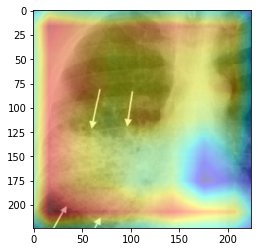

In [70]:

activated_features = SaveFeatures(model._modules.get('densenet121').features.denseblock4.denselayer16)
prediction = model(images)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
topk(pred_probabilities,1)

weight_softmax_params = list(model._modules.get('densenet121').classifier[0].parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
print(weight_softmax.shape)
class_idx = topk(pred_probabilities,1)[1].int()
class_idx

overlay=getCAM(activated_features.features, weight_softmax,class_idx)
from matplotlib.pyplot import imshow
imshow(overlay[0], alpha=0.5, cmap='jet')

import numpy as np
img = images[0].cpu().numpy()[0]
#convert image back to Height,Width,Channels
#img = np.transpose(img, (1,2,0))
print(img.shape)
imshow(img,cmap='gray')
imshow(skimage.transform.resize(overlay[0], images.shape[2:4]), alpha=0.4, cmap='jet');